In [63]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,summarize)
from sklearn.metrics import  r2_score,mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold

In [65]:
train = pd.read_csv('.\\train.csv',index_col= 'id')
test = pd.read_csv('.\\test.csv',index_col= 'id')

In [3]:
col  = train.columns
train
# MedInc	Median income in the area 
# HouseAge	Median age of houses in the area (in years)
# AveRooms	Average number of rooms per house
# AveBedrms	Average number of bedrooms per house
# Population	Population of the area
# AveOccup	Average number of occupants per household
# Latitude	Geographical latitude of the area
# Longitude	Geographical longitude of the area
# MedHouseVal	Median house value in the area

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
id                                                                             
0      2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
1      3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
2      4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   
3      2.4138      16.0  3.350203   0.965432      1255.0  2.089286     32.66   
4      3.7500      52.0  4.284404   1.069246      1793.0  1.604790     37.80   
...       ...       ...       ...        ...         ...       ...       ...   
37132  3.3438      50.0  4.936508   1.079365      1775.0  3.022222     34.19   
37133  3.7308      26.0  5.087533   0.966019      1006.0  4.316901     37.32   
37134  4.1716      52.0  4.678862   1.101485      1156.0  1.431734     37.75   
37135  2.7143      16.0  5.710074   1.068376       584.0  2.803659     38.40   
37136  2.2419      34.0  5.424419   1.058685      1340.0  3.799065     36.34   

       Longitude  MedHouseVal  
id                             
0        -120.12        0.980  
1        -121.22        0.946  
2        -120.45        1.576  
3        -117.09        1.336  
4        -122.41        4.500  
...          ...          ...  
37132    -118.36        1.856  
37133    -121.86        1.588  
37134    -122.44        3.387  
37135    -120.98        1.592  
37136    -119.64        0.652  

[37137 rows x 9 columns]

In [4]:
train.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  37137.000000  37137.000000  37137.000000  37137.000000  37137.000000   
mean       3.851029     26.057005      5.163124      1.062204   1660.778919   
std        1.803167     12.158221      1.206242      0.096490   1302.469608   
min        0.499900      2.000000      0.851064      0.500000      3.000000   
25%        2.602300     17.000000      4.357522      1.020305    952.000000   
50%        3.515600     25.000000      5.068611      1.054545   1383.000000   
75%        4.699700     35.000000      5.858597      1.088825   1856.000000   
max       15.000100     52.000000     28.837607      5.873181  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  37137.000000  37137.000000  37137.000000  37137.000000  
mean       2.831243     35.570030   -119.554329      2.079751  
std        2.702413      2.083179      1.974028      1.158571  
min        0.950000     32.550000   -124.350000      0.149990  
25%        2.394495     33.930000   -121.800000      1.208000  
50%        2.744828     34.190000   -118.450000      1.808000  
75%        3.125313     37.700000   -118.020000      2.660000  
max      502.990610     41.950000   -114.550000      5.000010

MedInc : The dataset contains a variety of income levels, from very low to relatively high. This suggests that housing values in areas with low-income households could be very different from those in high-income neighborhoods.

AveRooms : The average number of rooms is slightly above 5, suggesting that most homes in the dataset are medium-sized. The maximum value of 28.8 rooms indicates that some homes in the dataset may be quite large, such as mansions or multi-family units.

AveBedrms: With a mean of just over 1 bedroom per home, this suggests that many of the homes may be relatively small or that some bedrooms are potentially shared in larger homes (with many rooms but few distinct bedrooms).

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37137 entries, 0 to 37136
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       37137 non-null  float64
 1   HouseAge     37137 non-null  float64
 2   AveRooms     37137 non-null  float64
 3   AveBedrms    37137 non-null  float64
 4   Population   37137 non-null  float64
 5   AveOccup     37137 non-null  float64
 6   Latitude     37137 non-null  float64
 7   Longitude    37137 non-null  float64
 8   MedHouseVal  37137 non-null  float64
dtypes: float64(9)
memory usage: 2.8 MB


All the variables are float 

In [6]:
train

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
id                                                                             
0      2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
1      3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
2      4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   
3      2.4138      16.0  3.350203   0.965432      1255.0  2.089286     32.66   
4      3.7500      52.0  4.284404   1.069246      1793.0  1.604790     37.80   
...       ...       ...       ...        ...         ...       ...       ...   
37132  3.3438      50.0  4.936508   1.079365      1775.0  3.022222     34.19   
37133  3.7308      26.0  5.087533   0.966019      1006.0  4.316901     37.32   
37134  4.1716      52.0  4.678862   1.101485      1156.0  1.431734     37.75   
37135  2.7143      16.0  5.710074   1.068376       584.0  2.803659     38.40   
37136  2.2419      34.0  5.424419   1.058685      1340.0  3.799065     36.34   

       Longitude  MedHouseVal  
id                             
0        -120.12        0.980  
1        -121.22        0.946  
2        -120.45        1.576  
3        -117.09        1.336  
4        -122.41        4.500  
...          ...          ...  
37132    -118.36        1.856  
37133    -121.86        1.588  
37134    -122.44        3.387  
37135    -120.98        1.592  
37136    -119.64        0.652  

[37137 rows x 9 columns]

In [61]:
train.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
cluster        0
dtype: int64

There is no null values

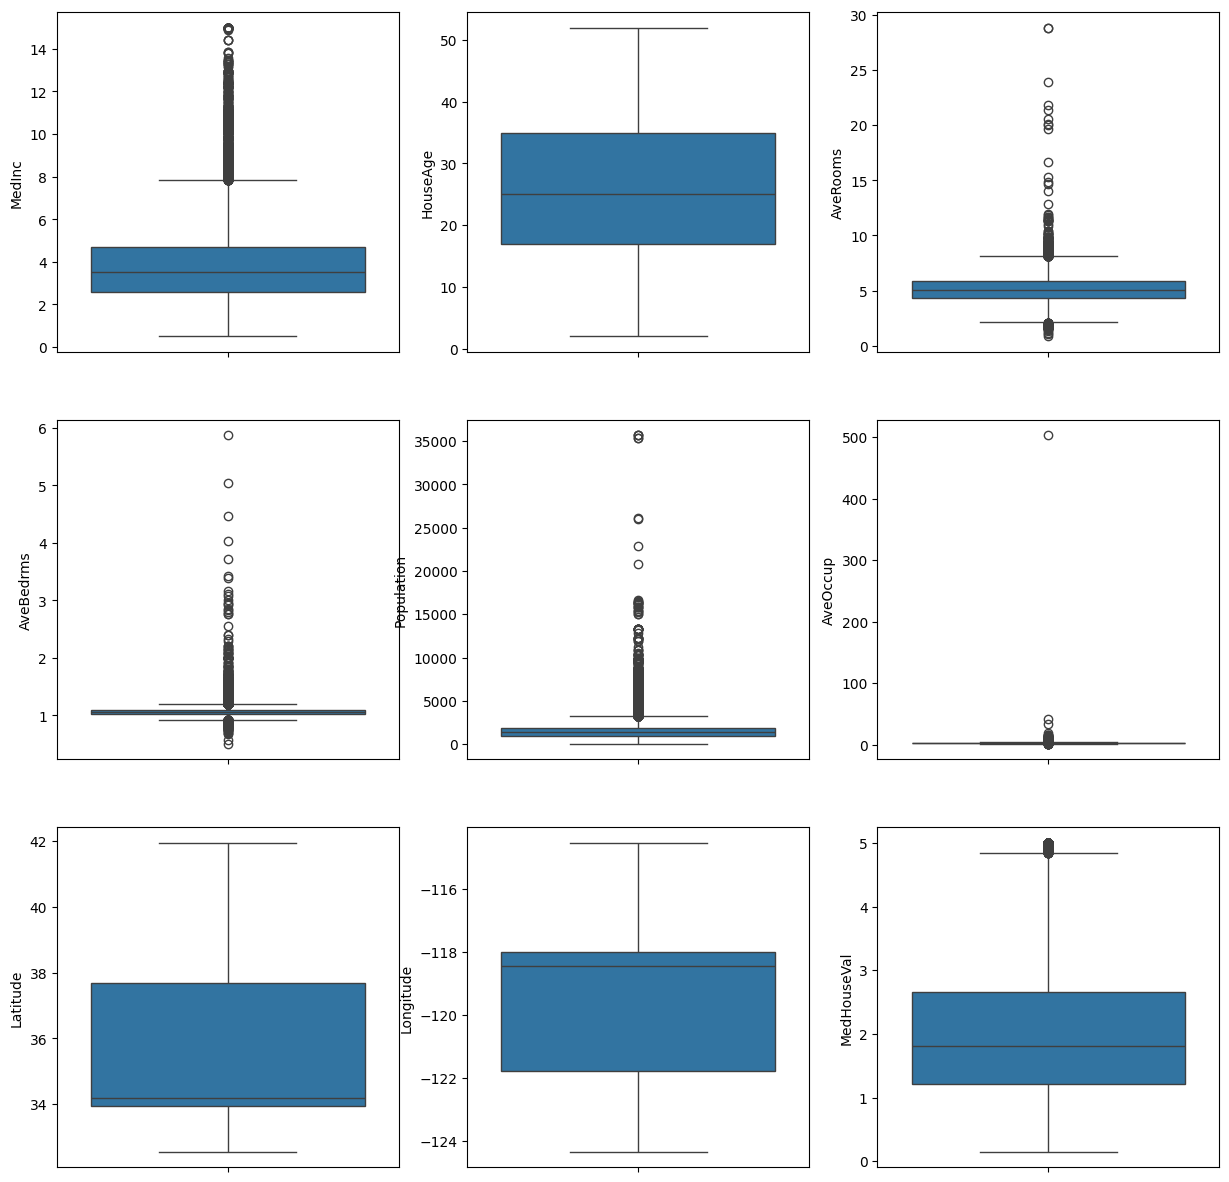

In [7]:
plt.figure(figsize=(15,15))
for i,colu in enumerate(col):
    plt.subplot(3,3,i+1)
    sns.boxplot(train[colu])

From the box plot we can able to say that it have some outlier for features of Medinc,averooms, averbedroom,population

In [8]:
train = pd.read_csv('.\\train.csv',index_col= 'id')
def remove_outlier(col:str,df):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col][(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df[col]

for i in col:
    if i not in ["Latitude","Longitude"]:
        train[i] = remove_outlier(i,train)
train.dropna()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
id                                                                             
0      2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
1      3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
2      4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   
3      2.4138      16.0  3.350203   0.965432      1255.0  2.089286     32.66   
4      3.7500      52.0  4.284404   1.069246      1793.0  1.604790     37.80   
...       ...       ...       ...        ...         ...       ...       ...   
37131  2.6913      17.0  3.492991   1.093207      1135.0  2.573770     34.20   
37132  3.3438      50.0  4.936508   1.079365      1775.0  3.022222     34.19   
37134  4.1716      52.0  4.678862   1.101485      1156.0  1.431734     37.75   
37135  2.7143      16.0  5.710074   1.068376       584.0  2.803659     38.40   
37136  2.2419      34.0  5.424419   1.058685      1340.0  3.799065     36.34   

       Longitude  MedHouseVal  
id                             
0        -120.12        0.980  
1        -121.22        0.946  
2        -120.45        1.576  
3        -117.09        1.336  
4        -122.41        4.500  
...          ...          ...  
37131    -118.48        2.063  
37132    -118.36        1.856  
37134    -122.44        3.387  
37135    -120.98        1.592  
37136    -119.64        0.652  

[29631 rows x 9 columns]

In [9]:
train

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
id                                                                             
0      2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
1      3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
2      4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   
3      2.4138      16.0  3.350203   0.965432      1255.0  2.089286     32.66   
4      3.7500      52.0  4.284404   1.069246      1793.0  1.604790     37.80   
...       ...       ...       ...        ...         ...       ...       ...   
37132  3.3438      50.0  4.936508   1.079365      1775.0  3.022222     34.19   
37133  3.7308      26.0  5.087533   0.966019      1006.0       NaN     37.32   
37134  4.1716      52.0  4.678862   1.101485      1156.0  1.431734     37.75   
37135  2.7143      16.0  5.710074   1.068376       584.0  2.803659     38.40   
37136  2.2419      34.0  5.424419   1.058685      1340.0  3.799065     36.34   

       Longitude  MedHouseVal  
id                             
0        -120.12        0.980  
1        -121.22        0.946  
2        -120.45        1.576  
3        -117.09        1.336  
4        -122.41        4.500  
...          ...          ...  
37132    -118.36        1.856  
37133    -121.86        1.588  
37134    -122.44        3.387  
37135    -120.98        1.592  
37136    -119.64        0.652  

[37137 rows x 9 columns]

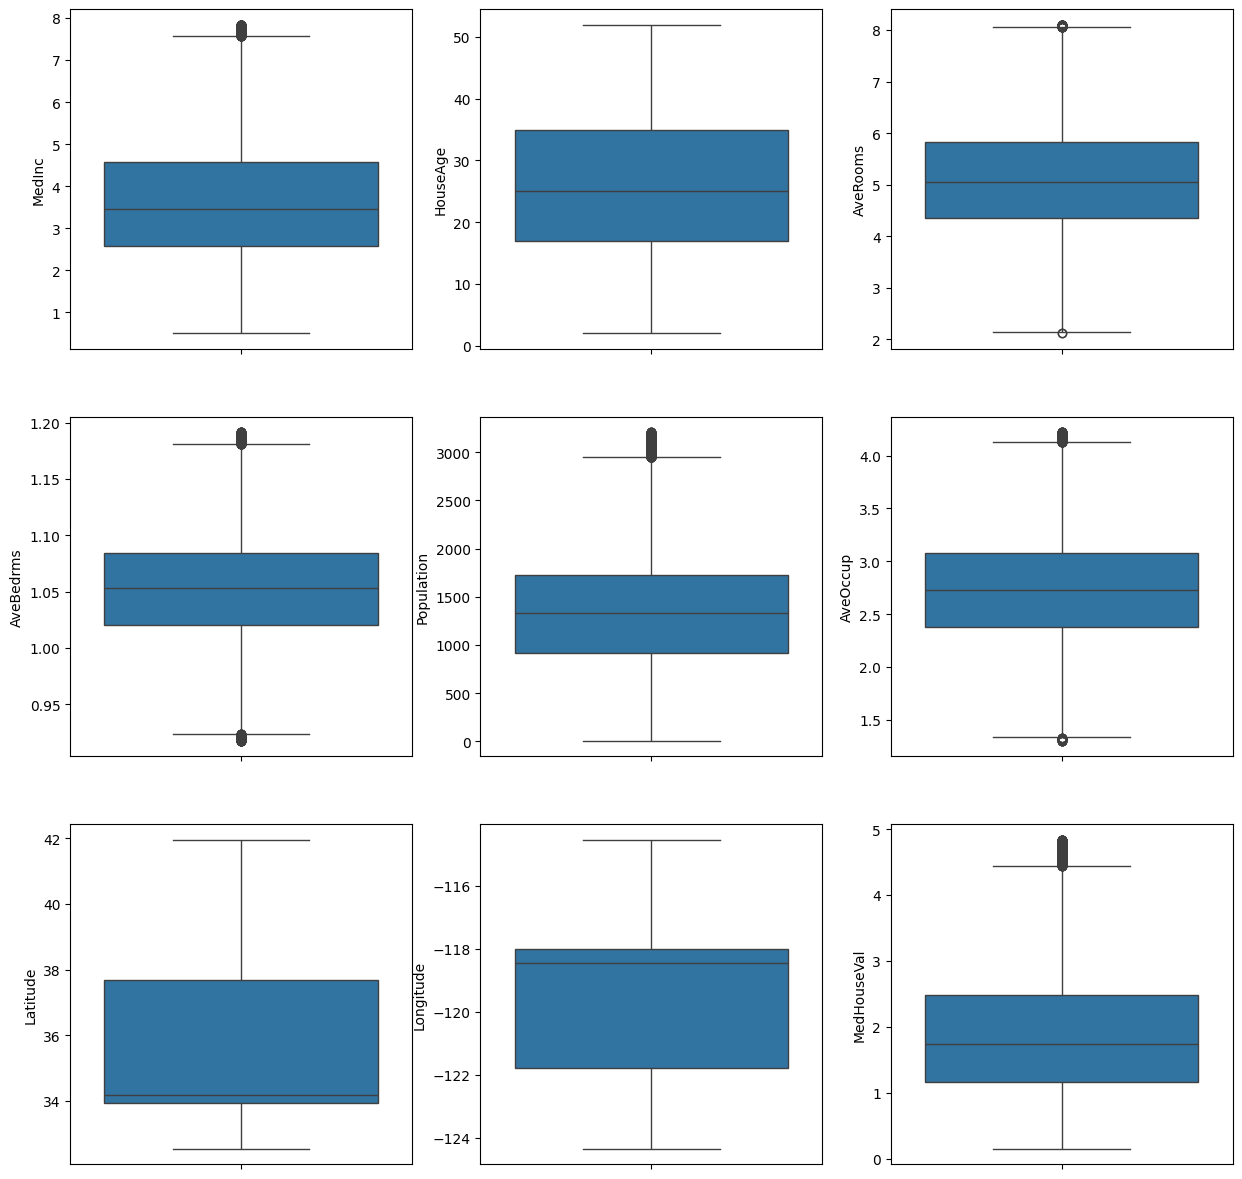

In [10]:
plt.figure(figsize=(15,15))
for i,colu in enumerate(col):
    plt.subplot(3,3,i+1)
    sns.boxplot(train[colu])

There is a significant reduction in outliers 

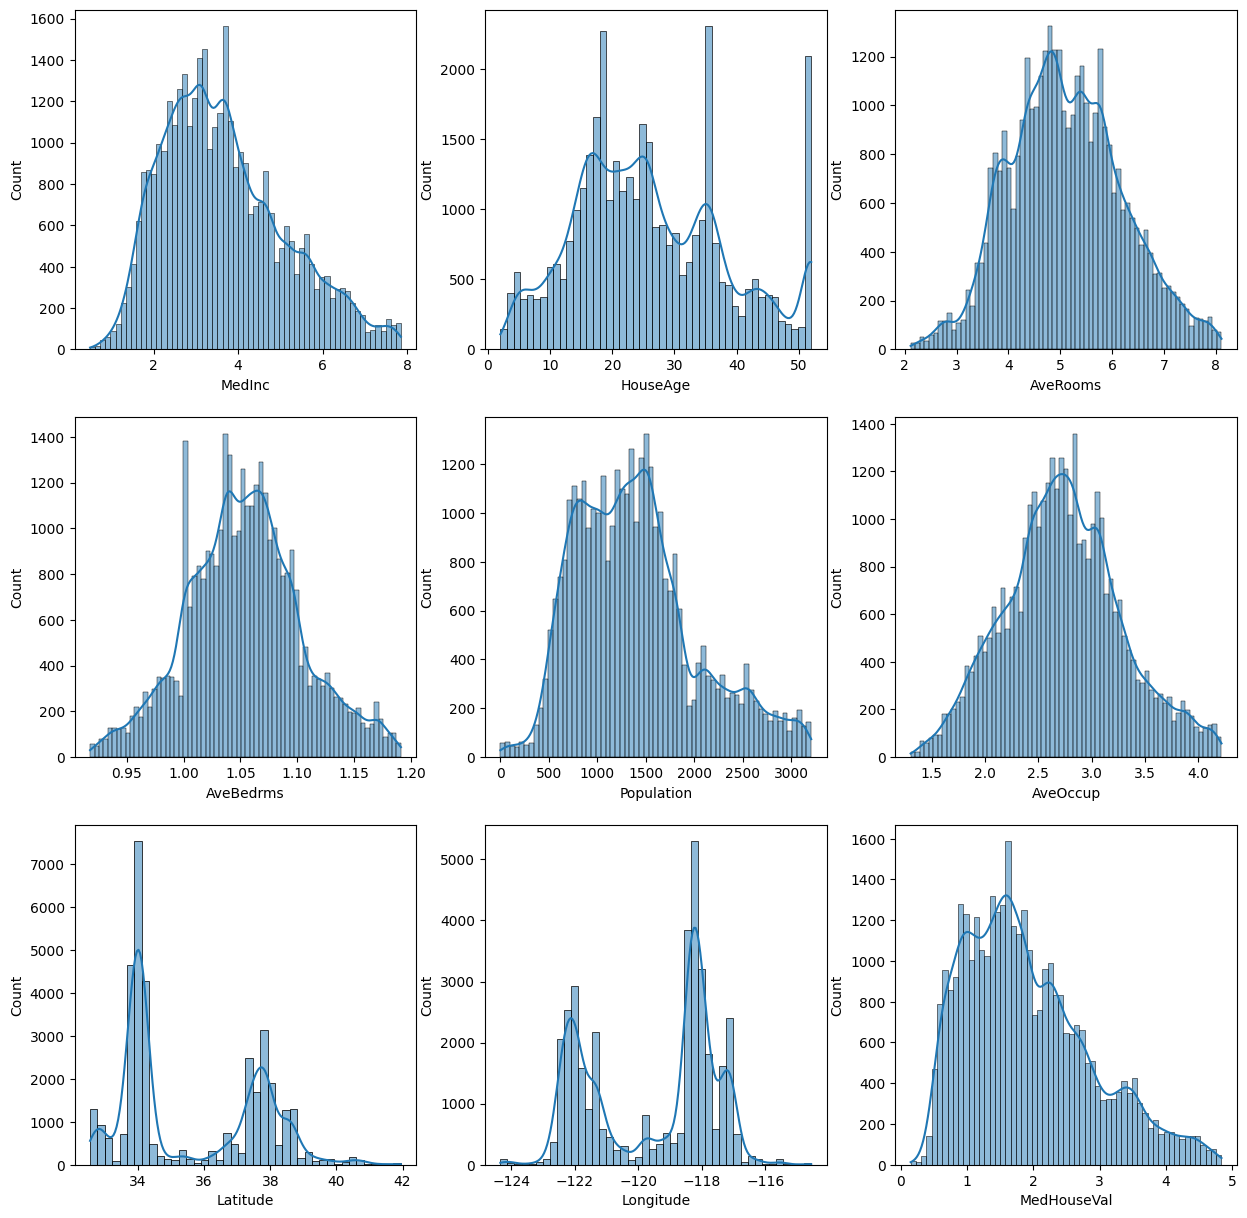

In [11]:
plt.figure(figsize=(15,15))
for i,colu in enumerate(col):
    plt.subplot(3,3,i+1)
    sns.histplot(train[colu], kde=True)

In [ ]:
# MedInc (Median Income): The distribution is a little right-skewed, with most values clustered between 2 and 5. This suggests that the majority of the population has a lower income range, with fewer high-income observations.

# HouseAge: This distribution shows multiple peaks, suggesting certain age ranges are more common (.

# AveRooms (Average Rooms): This histogram is roughly symmetrical and centered around a median number of rooms, with most values between 3 and 7. Extreme values in the lower and higher ranges are less frequent.

# AveBedrms (Average Bedrooms): Similar to AveRooms, this feature has a symmetrical distribution, with most values between 0.95 and 1.15. This suggests a typical bedroom-to-room ratio that doesn’t vary significantly across the data.

# Population: This feature appears to have a bimodal distribution, with peaks at certain population sizes, possibly indicating clustered population densities.

# AveOccup (Average Occupancy): The distribution is approximately normal and centered around 2 to 3 occupants, indicating that most households have a small number of people.

# MedHouseVal (Median House Value): This distribution is a little right-skewed, with a large number of properties clustered at lower values and a few at higher values, indicating that higher-value properties are less common.

In [20]:
train.skew()

MedInc           1.567604
HouseAge         0.413457
AveRooms         1.301106
AveBedrms       12.965449
Population       5.796582
AveOccup       170.890130
Latitude         0.439251
Longitude       -0.313242
MedHouseVal      0.970856
dtype: float64

In [21]:
train['MedInc'] = np.log(train['MedInc'])
train['HouseAge'] = np.log(train['AveBedrms'])
train['Population'] = np.log(train['Population'])
train.skew()

MedInc          -0.025907
HouseAge         3.848335
AveRooms         1.301106
AveBedrms       12.965449
Population      -0.450777
AveOccup       170.890130
Latitude         0.439251
Longitude       -0.313242
MedHouseVal      0.970856
dtype: float64

<Axes: >

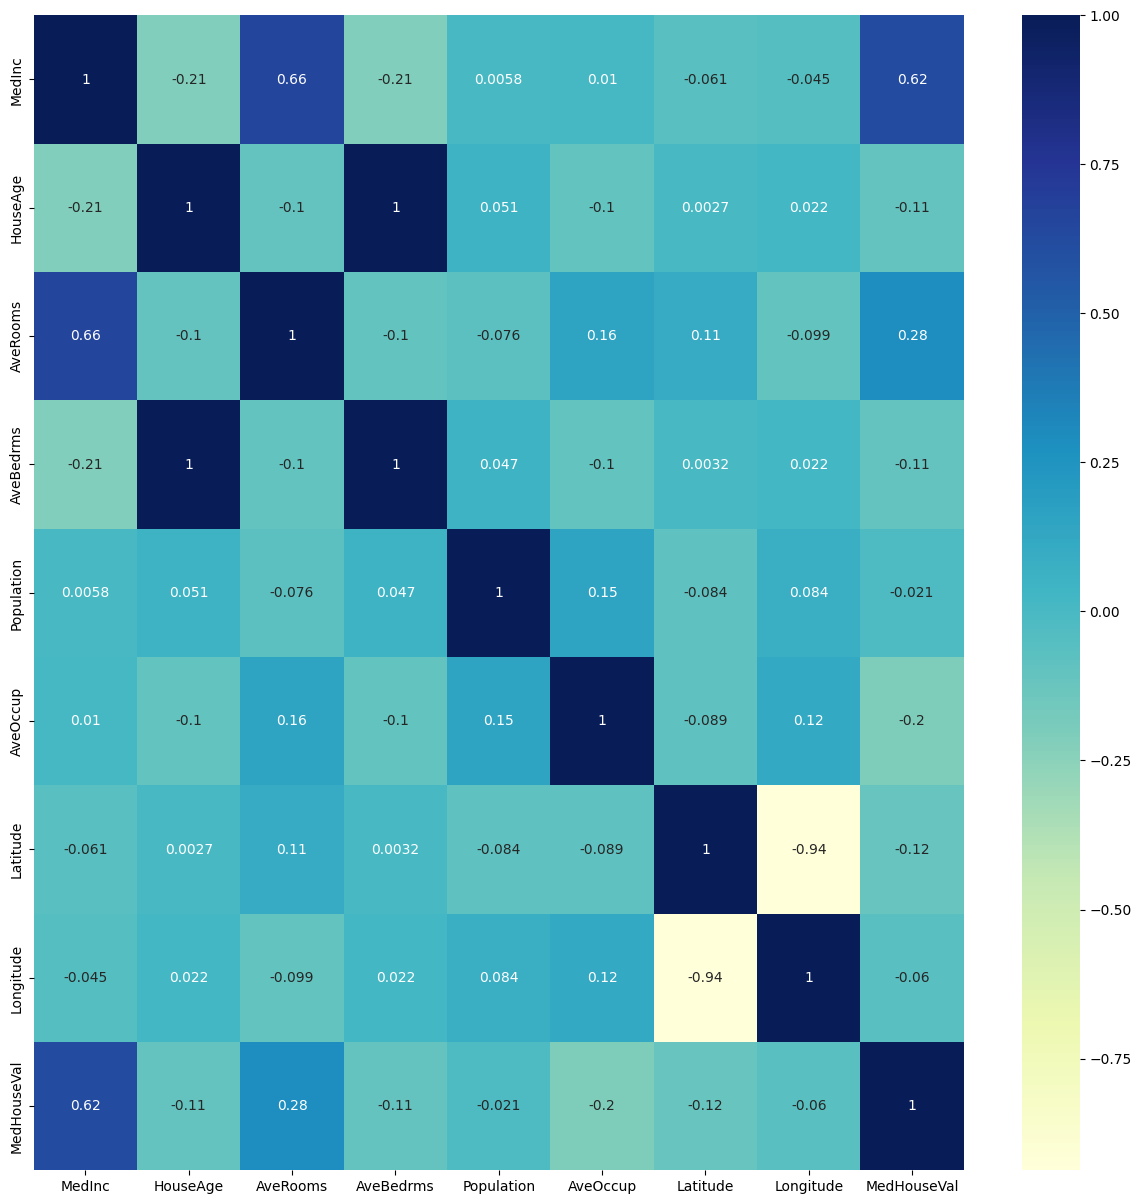

In [14]:
plt.figure(figsize= (15, 15))
sns.heatmap(train.corr(), annot = True,cmap="YlGnBu")

In [58]:
# 1: MedInc (Median Income):
# Strong positive correlation with MedHouseVal (0.62). This suggests that higher median income is associated with higher house values, which is expected in housing data.
# Moderate positive correlation with AveRooms (0.66), indicating that higher income areas tend to have more rooms in houses.

# 2:HouseAge:
# Weak negative correlation with MedHouseVal (-0.11). This suggests that newer houses might have slightly higher values compared to older ones, though the relationship is weak.

# 3:AveRooms (Average Rooms):
# Moderate positive correlation with MedHouseVal (0.28), suggesting that houses with more rooms tend to have higher values.
# Positive correlation with MedInc (0.66), indicating that areas with larger homes tend to have higher incomes.

# 4:AveBedrms (Average Bedrooms):
# Weak negative correlation with MedHouseVal (-0.11). This could imply that higher house values are not necessarily associated with more bedrooms.

# 5:Population:
# Very low correlations with other features, suggesting that population size alone does not strongly influence house characteristics or values in this dataset.

# 6:AveOccup (Average Occupancy):
# Very low correlations with most features, though there’s a slight negative correlation with Latitude and Longitude. This suggests that occupancy might vary slightly with location but does not strongly impact other variables.

# 7:MedHouseVal (Median House Value):
# Aside from its positive correlation with MedInc and AveRooms, MedHouseVal shows minimal correlation with most other features, suggesting that factors like income and house size are more significant determinants of house value in this dataset than population or occupancy.

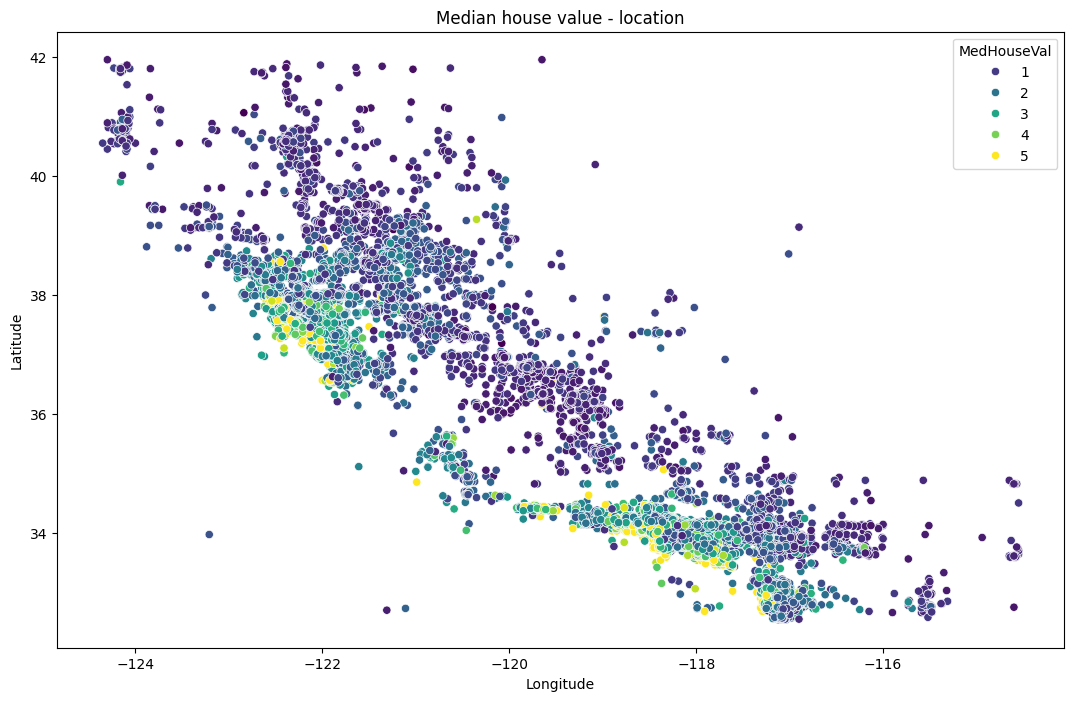

In [22]:
plt.figure(figsize=(13,8))
sns.scatterplot(data = train, x = "Longitude", y = "Latitude",hue = "MedHouseVal", palette = "viridis")
plt.title("Median house value - location")
plt.show()

In [59]:
# using latitude and longitude for visvalisation of the satate

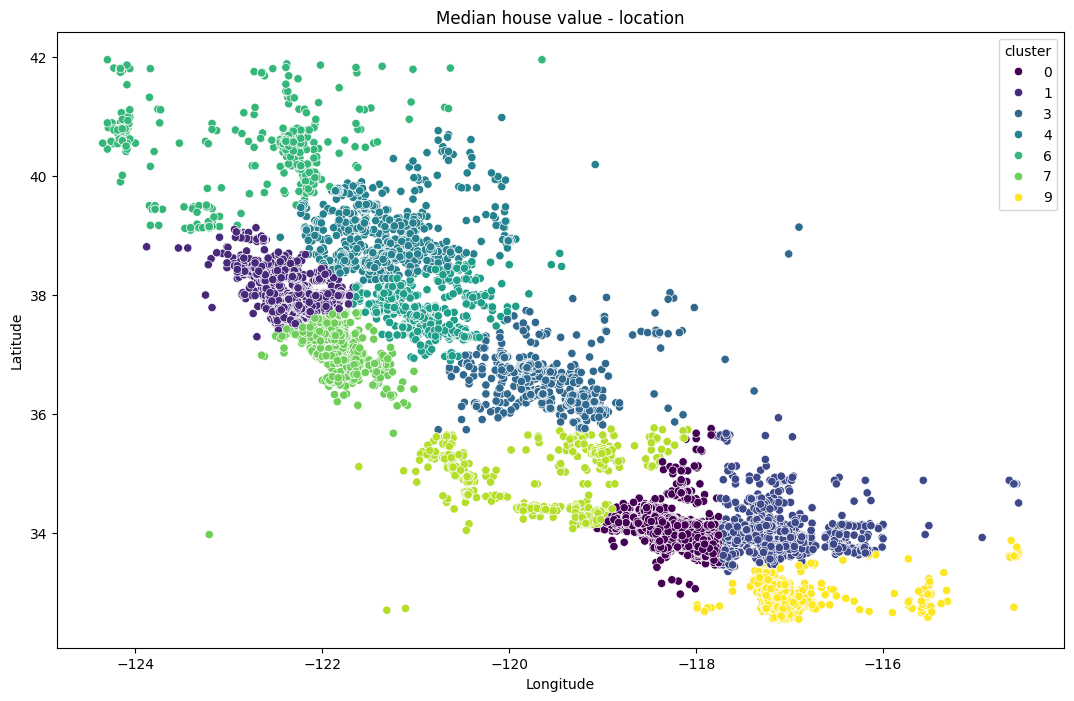

In [23]:
from sklearn.cluster import KMeans
kmeans =  KMeans(n_clusters=10).fit(train.iloc[:,6:8])
train['cluster'] = kmeans.labels_
kmeans =  KMeans(n_clusters=10).fit(test.iloc[:,6:8])
test['cluster'] = kmeans.labels_
plt.figure(figsize=(13,8))
sns.scatterplot(data = train, x = "Longitude", y = "Latitude",hue = "cluster", palette = "viridis")
plt.title("Median house value - location")
plt.show()

In [60]:
# convert the coordinates points into clusters so that we can able to better predict the value

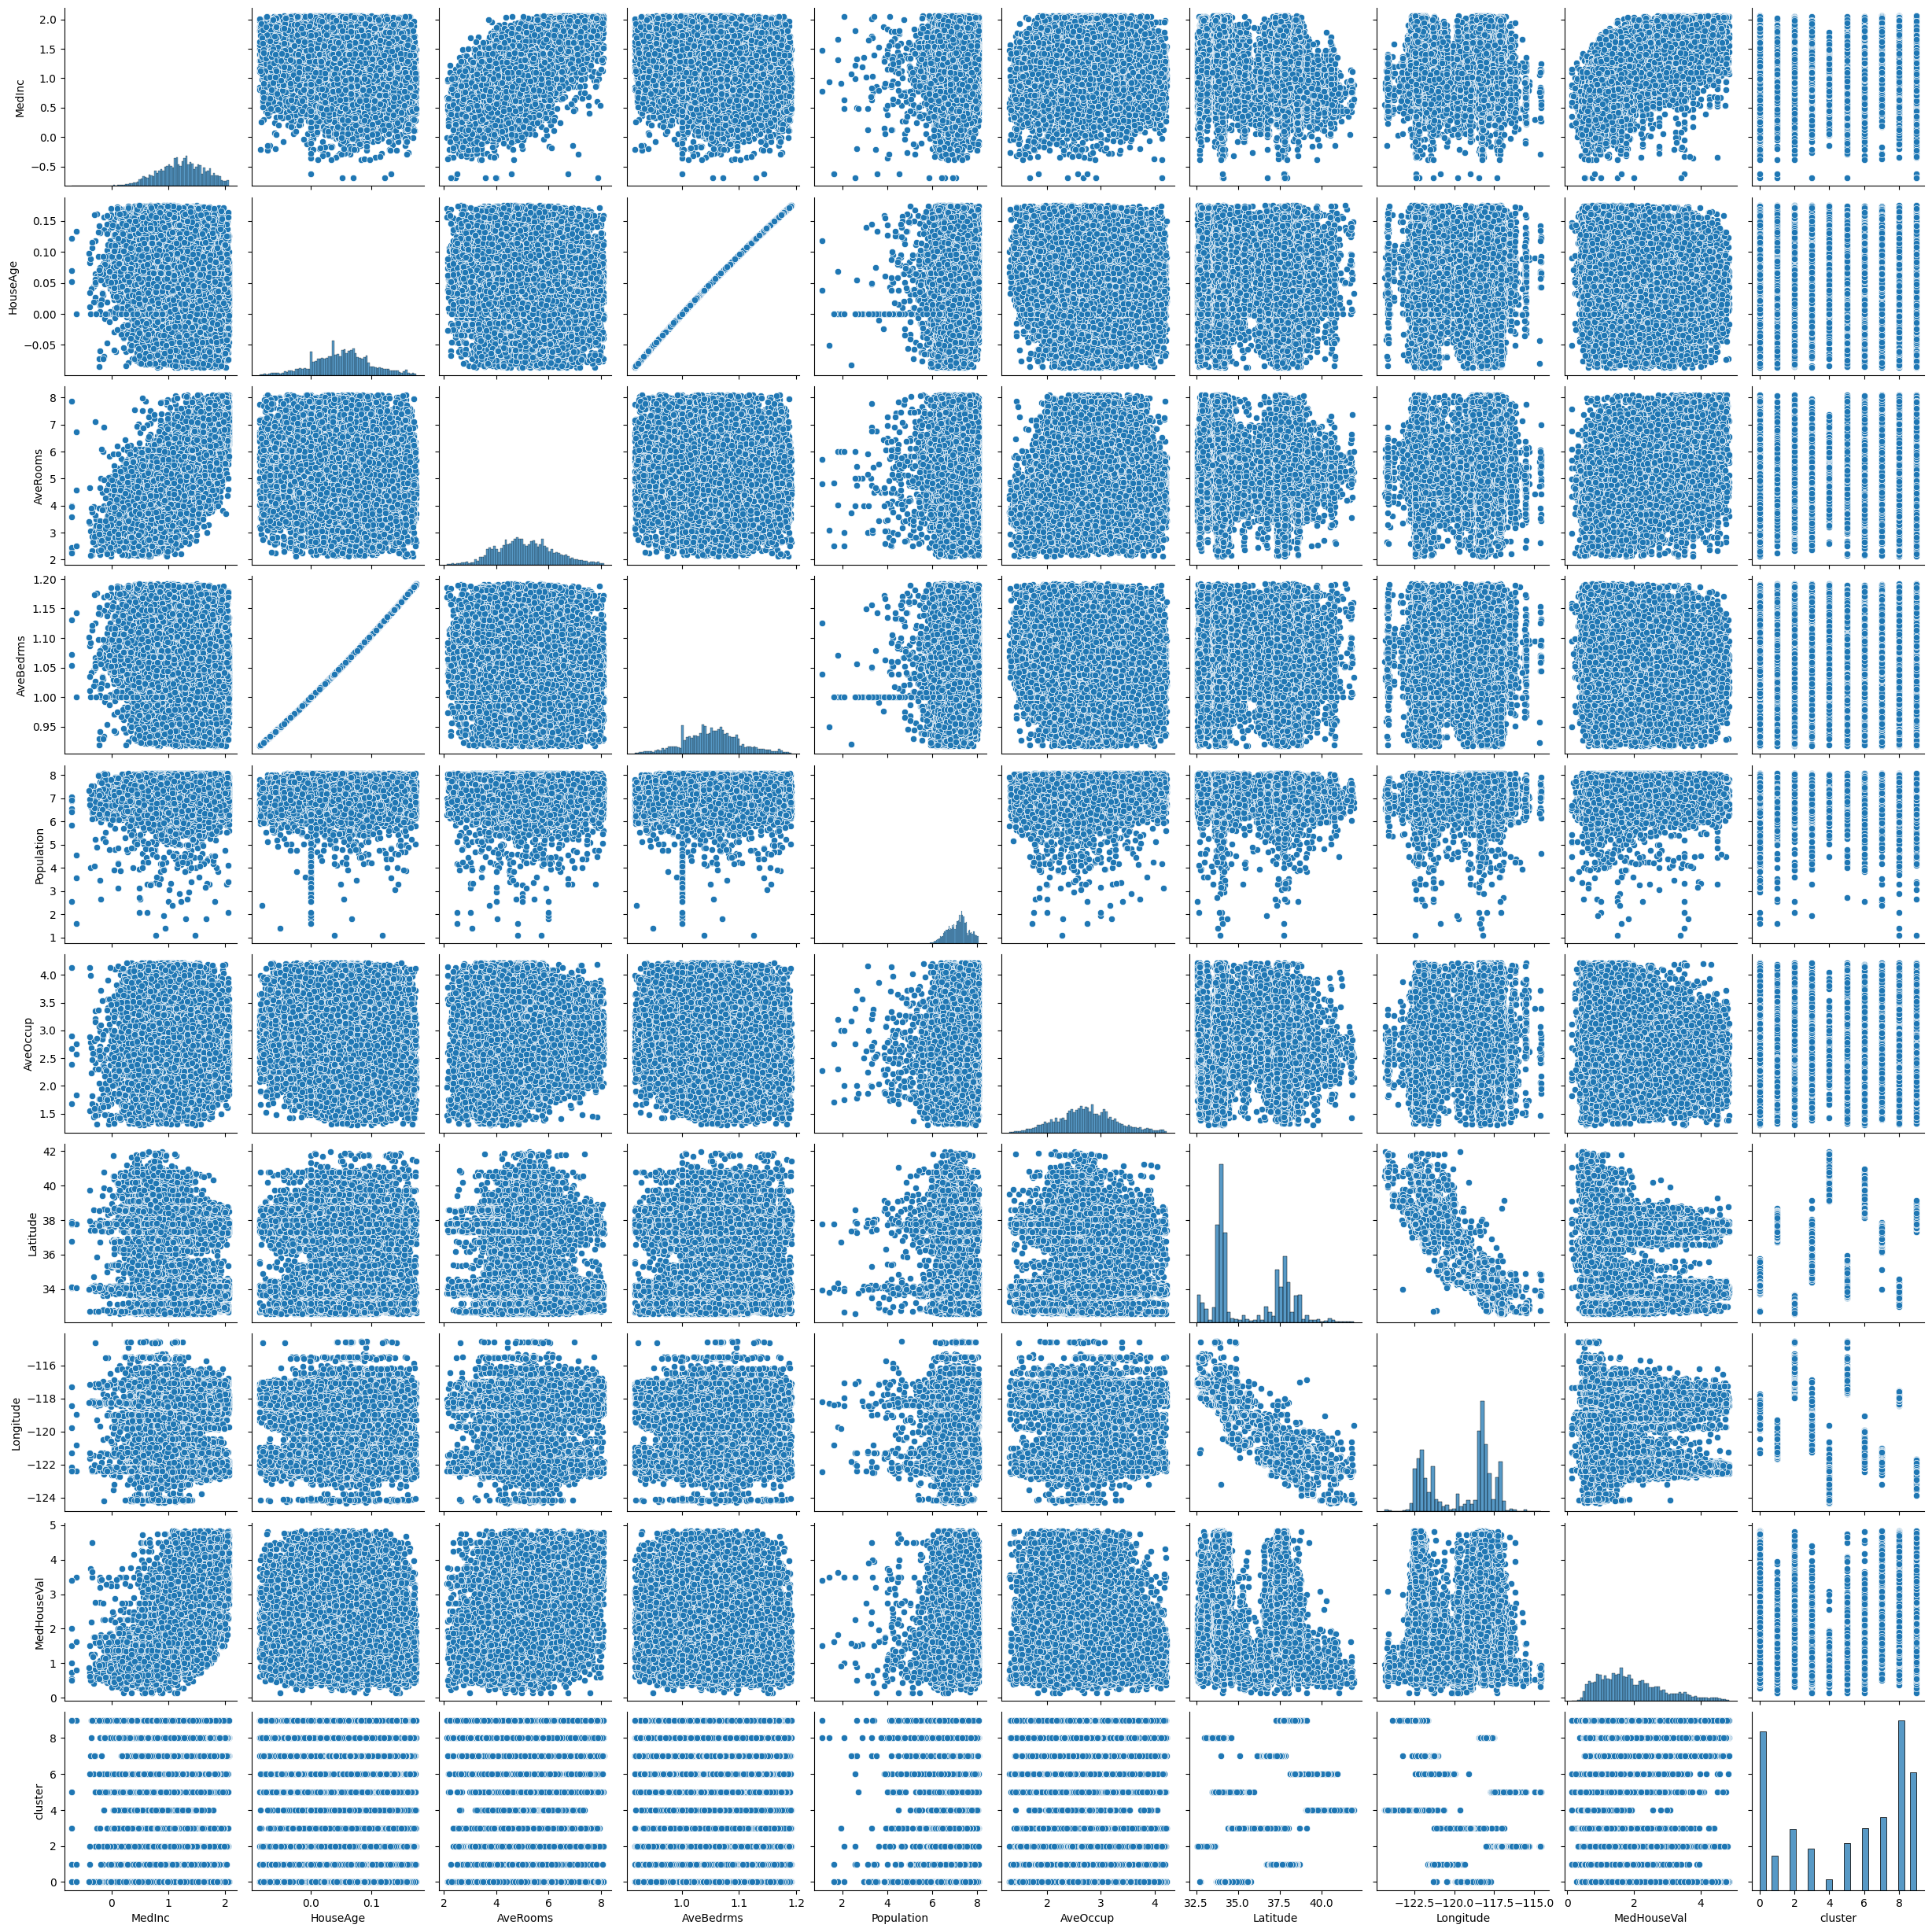

In [17]:
sns.pairplot(train)

In [ ]:
# MedInc (Median Income) vs. MedHouseVal (Median House Value):
# There’s a positive linear relationship between median income and median house value, indicating that as income increases, house values also tend to increase.
# This relationship aligns with the correlation matrix, where these features were positively correlated.

# AveRooms (Average Rooms) vs. MedInc:
# There appears to be a slight positive relationship, where higher income areas tend to have homes with more rooms.
# However, the relationship has some spread, indicating variability in room numbers even at similar income levels.

# AveRooms vs. AveBedrms (Average Bedrooms):
# These features show a positive correlation, though with some dispersion. As the average number of rooms increases, so does the average number of bedrooms, but the relationship isn’t perfectly linear.
# There are cases where homes have more rooms without a corresponding increase in bedrooms, which might indicate larger living spaces or additional rooms used for other purposes.

# Population vs. MedHouseVal:
# The scatter plot between population and house value shows no clear pattern, which indicates that population size does not significantly impact house values in this dataset.

# HouseAge (Age of the House):
# Plots involving HouseAge and other features like MedHouseVal and MedInc show some dispersion but no clear patterns, suggesting that house age has a limited direct impact on income or house value in this dataset.

# AveOccup (Average Occupancy):
# Scatter plots involving average occupancy and other features don’t show strong relationships, which indicates that occupancy doesn’t correlate well with other variables such as house size, value, or location.

In [24]:
for i in train:
    if i == "Latitude":
        break
    X = MS([i,"MedHouseVal"]).fit_transform(train)
    model = sm.OLS(train[i],train["MedHouseVal"])
    res = model.fit()
    print(summarize(res),i)
    

             coef  std err        t  P>|t|
MedHouseVal  0.52    0.001  501.052    0.0 MedInc
               coef  std err        t  P>|t|
MedHouseVal  0.0199      0.0  115.208    0.0 HouseAge
               coef  std err        t  P>|t|
MedHouseVal  1.9851    0.005  378.796    0.0 AveRooms
               coef  std err        t  P>|t|
MedHouseVal  0.3884    0.001  335.357    0.0 AveBedrms
               coef  std err        t  P>|t|
MedHouseVal  2.6418    0.008  335.786    0.0 Population
               coef  std err        t  P>|t|
MedHouseVal  1.0122    0.007  150.556    0.0 AveOccup


In [68]:
from sklearn.model_selection import train_test_split
X = train.drop(['MedHouseVal'],axis=1)
y =train['MedHouseVal']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

In [75]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model_pred = lr_model.predict(X_test.values)
print("Mean Squared Error",mean_squared_error(y_test, lr_model_pred))

Mean Squared Error 0.6089855115858647


c:\Users\shuga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [76]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)
rf_model_pred = rf_model.predict(X_test.values)
print("Mean Squared Error",mean_squared_error(y_test, rf_model_pred))

Mean Squared Error 0.7428692725740721


c:\Users\shuga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [81]:
from sklearn.tree import DecisionTreeRegressor
dec_model = DecisionTreeRegressor()
dec_model.fit(X_train, y_train)
pred_dec= dec_model.predict(X_test.values)
print("Mean Squared Error",mean_squared_error(y_test, pred_dec))

Mean Squared Error 0.6898762645097604


c:\Users\shuga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [ ]:
rmses = []
clfs =[]
N_ESTIMATORS = 100_000
features = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']
target = 'MedHouseVal'
kf = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, val_index in kf.split(train):
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]

    clf = CatBoostRegressor(iterations=N_ESTIMATORS, loss_function='RMSE')
    clf.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=1000, verbose=False)
    
    
    preds = clf.predict(X_val.values)
    
    clfs.append(clf)
    rmses.append(mean_squared_error(y_val, preds, squared=False))
print(f'mean RMSE across all folds: {np.mean(rmses)}')

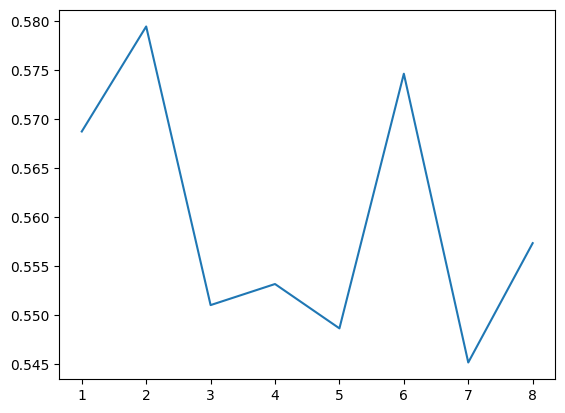

In [101]:
ra = range(1,9)
plt.plot(ra,rmses)
plt.show()